In [1]:
import pandas as pd
import numpy as np
from random import sample
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./wikitext-2/cvaw4.csv')

In [3]:
sentiment_index=[]
for f in [0, 1, 2, 3, 4]:
    print('fold: {}'.format(f))
    train = pd.read_csv('train{}.csv'.format(f), header=None)
    test = pd.read_csv('test{}.csv'.format(f), header=None)
    val = pd.read_csv('val{}.csv'.format(f), header=None)
    for t in [train, test, val]:
        kw = [([w.split('(')[:-1][0] for w in l.split(' ')]) for l in t[1]]
        index = []
        for i,s in enumerate(kw):
            if len((set(s) & set(list(df['Word'])))) >0:
                index.append(i)
        print('coverage :', len(index)/len(kw))
        sentiment_index.append(index)

fold: 0
coverage : 0.8729863692688972
coverage : 0.8586956521739131
coverage : 0.8217391304347826
fold: 1
coverage : 0.8667079975201488
coverage : 0.8676789587852495
coverage : 0.8478260869565217
fold: 2
coverage : 0.866088034717917
coverage : 0.8655097613882863
coverage : 0.8565217391304348
fold: 3
coverage : 0.8586484810911346
coverage : 0.8720173535791758
coverage : 0.8956521739130435
fold: 4
coverage : 0.8648481091134532
coverage : 0.8611713665943601
coverage : 0.8739130434782608


In [4]:
def evaluate(df, index, SW=True):
    if SW == True:
        temp_df = df.loc[index]
    else:
        temp_df = df.loc[~df.index.isin(index)]
    RMSE_V = mean_squared_error(temp_df['labelV'], temp_df['predictV'], squared=False)
    RMSE_A = mean_squared_error(temp_df['labelA'], temp_df['predictA'], squared=False)
    MAE_V = mean_absolute_error(temp_df['labelV'], temp_df['predictV'])
    MAE_A = mean_absolute_error(temp_df['labelA'], temp_df['predictA'])
    R_V = r2_score(temp_df['labelV'], temp_df['predictV'])
    R_A = r2_score(temp_df['labelA'], temp_df['predictA'])
    MDAE_V = median_absolute_error(temp_df['labelV'], temp_df['predictV'])
    MDAE_A = median_absolute_error(temp_df['labelA'], temp_df['predictA'])
    return (RMSE_V+RMSE_A), (MAE_V+MAE_A), (R_V+R_A), (MDAE_V+MDAE_A)

In [5]:
def calculate(mlm, alpha, model):
    result = []
    if model == 'VA_BERT_no_mask':
        fold0 = pd.read_csv('../output/VA_BERT_alpha230/VA_BERT_no_mask/output/original/fold0/test_predict.csv')
        fold1 = pd.read_csv('../output/VA_BERT_alpha230/VA_BERT_no_mask/output/original/fold1/test_predict.csv')
        fold2 = pd.read_csv('../output/VA_BERT_alpha230/VA_BERT_no_mask/output/original/fold2/test_predict.csv')
        fold3 = pd.read_csv('../output/VA_BERT_alpha230/VA_BERT_no_mask/output/original/fold3/test_predict.csv')
        fold4 = pd.read_csv('../output/VA_BERT_alpha230/VA_BERT_no_mask/output/original/fold4/test_predict.csv')
    else:
        fold0 = pd.read_csv('../output/VA_BERT_alpha230/{}/output/fold0/output{}/alpha{}/test_predict{}.csv'.format(model, mlm, alpha, mlm))
        fold1 = pd.read_csv('../output/VA_BERT_alpha230/{}/output/fold1/output{}/alpha{}/test_predict{}.csv'.format(model, mlm, alpha, mlm))
        fold2 = pd.read_csv('../output/VA_BERT_alpha230/{}/output/fold2/output{}/alpha{}/test_predict{}.csv'.format(model, mlm, alpha, mlm))
        fold3 = pd.read_csv('../output/VA_BERT_alpha230/{}/output/fold3/output{}/alpha{}/test_predict{}.csv'.format(model, mlm, alpha, mlm))
        fold4 = pd.read_csv('../output/VA_BERT_alpha230/{}/output/fold4/output{}/alpha{}/test_predict{}.csv'.format(model, mlm, alpha, mlm))
    for d in [fold0, fold1, fold2, fold3, fold4]:
        temp=[]
        for index in ['labelV', 'labelA', 'predictV', 'predictA']:
            temp.append([eval(i)[0] for i in list(d[index])])
        result.append(temp)

    for i,c in enumerate(['labelV', 'labelA', 'predictV', 'predictA']):
        fold0[c] = result[0][i]
        fold1[c] = result[1][i]
        fold2[c] = result[2][i]
        fold3[c] = result[3][i]
        fold4[c] = result[4][i]

    RMSE_T = 0
    MAE_T = 0
    R_T = 0
    MDAE_T = 0

    RMSE_F = 0
    MAE_F = 0
    R_F = 0
    MDAE_F = 0
    for sw in ['Y','N']:    
        for i,(df, index) in enumerate([(fold0, sentiment_index[1]), (fold1, sentiment_index[4]), (fold2, sentiment_index[7]), (fold3, sentiment_index[10]), (fold4, sentiment_index[13])]):
            if sw == 'Y':
                RMSE, MAE, R, MDAE = evaluate(df, index)
                RMSE_T += RMSE
                MAE_T += MAE
                R_T += R
                MDAE_T += MDAE
            else:
                RMSE, MAE, R, MDAE = evaluate(df, index, SW=False)
                RMSE_F += RMSE
                MAE_F += MAE
                R_F += R
                MDAE_F += MDAE
    return RMSE_T/5, MAE_T/5, R_T/5, MDAE_T/5, RMSE_F/5, MAE_F/5, R_F/5, MDAE_F/5

In [6]:
df = pd.DataFrame({'model':[], 'mlm':[], 'alpha':[],'YSW_RMSE':[],'YSW_MAE':[],'YSW_R':[],'YSW_MDAE':[],'NSW_RMSE':[],'NSW_MAE':[],'NSW_R':[],'NSW_MDAE':[]})
l = [(0,0,'VA_BERT_no_mask'),
     (0.05, 0.6, 'VA_BERT_random_mask'),
     (0.1, 1, 'VA_BERT_mask_sentiment'),
     (0.35, 1, 'VA_BERT_mask_sentiment_prob_V'),
     (0.15, 1, 'VA_BERT_mask_sentiment_prob_reverse_V'),
     (0.2, 1, 'VA_BERT_mask_sentiment_prob_A'),
     (0.25, 0.8,'VA_BERT_mask_sentiment_prob_reverse_A'),
     (0.2, 1,'VA_BERT_mask_sentiment_prob_Union'),
     (0.3, 0.6,'VA_BERT_mask_sentiment_prob_Intersection'),
     (0.45, 1, 'VA_BERT_mask_sentiment_prob_Union_reverse'),
     (0.5, 0.8, 'VA_BERT_mask_sentiment_prob_Intersection_reverse')
     ]
for mlm, alpha, model in l:
    RMSE_T, MAE_T, R_T, MDAE_T, RMSE_F, MAE_F, R_F, MDAE_F = calculate(mlm, alpha, model)
    d_temp = {'model':model, 'mlm':mlm, "alpha":alpha, 'YSW_RMSE':RMSE_T,'YSW_MAE':MAE_T, 'YSW_MDAE':MDAE_T, 'YSW_R':R_T,'NSW_RMSE':RMSE_F,'NSW_MAE':MAE_F,'NSW_R':R_F,'NSW_MDAE':MDAE_F}
    df = df.append(d_temp, ignore_index=True)

In [7]:
df

,model,mlm,alpha,YSW_RMSE,YSW_MAE,YSW_R,YSW_MDAE,NSW_RMSE,NSW_MAE,NSW_R,NSW_MDAE
0,VA_BERT_no_mask,0.00,0.0,1.358770,1.058360,0.815311,0.870416,1.478967,1.139723,0.589000,0.920863
1,VA_BERT_random_mask,0.05,0.6,1.349117,1.037815,0.829048,0.828541,1.510580,1.144431,0.508402,0.894056
2,VA_BERT_mask_sentiment,0.10,1.0,1.405628,1.083570,0.731315,0.864860,1.543692,1.177263,0.448930,0.960799
3,VA_BERT_mask_sentiment_prob_V,0.35,1.0,1.456691,1.108502,0.626873,0.868210,1.520450,1.155563,0.503224,0.913379
4,VA_BERT_mask_sentiment_prob_reverse_V,0.15,1.0,1.359794,1.049216,0.819790,0.843162,1.538357,1.171119,0.461046,0.950992
5,VA_BERT_mask_sentiment_prob_A,0.20,1.0,1.406134,1.084855,0.719666,0.874459,1.532403,1.160588,0.487399,0.865385
6,VA_BERT_mask_sentiment_prob_reverse_A,0.25,0.8,1.398848,1.074785,0.740688,0.847987,1.568689,1.211990,0.419301,0.925955
7,VA_BERT_mask_sentiment_prob_Union,0.20,1.0,1.354220,1.051602,0.819505,0.848560,1.499125,1.157168,0.542491,0.970106
8,VA_BERT_mask_sentiment_prob_Intersection,0.30,0.6,1.330129,1.027413,0.861153,0.832632,1.486687,1.143000,0.582571,0.925858
9,VA_BERT_mask_sentiment_prob_Union_reverse,0.45,1.0,1.346306,1.048497,0.833200,0.863020,1.502608,1.166299,0.529212,0.965667


In [8]:
df

,model,mlm,alpha,YSW_RMSE,YSW_MAE,YSW_R,YSW_MDAE,NSW_RMSE,NSW_MAE,NSW_R,NSW_MDAE
0,VA_BERT_no_mask,0.00,0.0,1.358770,1.058360,0.815311,0.870416,1.478967,1.139723,0.589000,0.920863
1,VA_BERT_random_mask,0.05,0.6,1.349117,1.037815,0.829048,0.828541,1.510580,1.144431,0.508402,0.894056
2,VA_BERT_mask_sentiment,0.10,1.0,1.405628,1.083570,0.731315,0.864860,1.543692,1.177263,0.448930,0.960799
3,VA_BERT_mask_sentiment_prob_V,0.35,1.0,1.456691,1.108502,0.626873,0.868210,1.520450,1.155563,0.503224,0.913379
4,VA_BERT_mask_sentiment_prob_reverse_V,0.15,1.0,1.359794,1.049216,0.819790,0.843162,1.538357,1.171119,0.461046,0.950992
5,VA_BERT_mask_sentiment_prob_A,0.20,1.0,1.406134,1.084855,0.719666,0.874459,1.532403,1.160588,0.487399,0.865385
6,VA_BERT_mask_sentiment_prob_reverse_A,0.25,0.8,1.398848,1.074785,0.740688,0.847987,1.568689,1.211990,0.419301,0.925955
7,VA_BERT_mask_sentiment_prob_Union,0.20,1.0,1.354220,1.051602,0.819505,0.848560,1.499125,1.157168,0.542491,0.970106
8,VA_BERT_mask_sentiment_prob_Intersection,0.30,0.6,1.330129,1.027413,0.861153,0.832632,1.486687,1.143000,0.582571,0.925858
9,VA_BERT_mask_sentiment_prob_Union_reverse,0.45,1.0,1.346306,1.048497,0.833200,0.863020,1.502608,1.166299,0.529212,0.965667


In [9]:
#字數統計
df = pd.read_csv('train0.csv', header=None)

In [10]:
len(sum([([w.split('(')[0] for w in i.split(' ')]) for i in df[1]], []))

8097

In [18]:
mask_word_count = {'VA_BERT_random_mask': 631, 
                   'VA_BERT_mask_sentiment':604, 
                   'VA_BERT_mask_sentiment_prob_V':517,
                   'VA_BERT_mask_sentiment_prob_reverse_V':407,
                   'VA_BERT_mask_sentiment_prob_A':422,
                   'VA_BERT_mask_sentiment_prob_reverse_A':540,
                   'VA_BERT_mask_sentiment_prob_Union':585,
                   'VA_BERT_mask_sentiment_prob_Intersection':268,
                   'VA_BERT_mask_sentiment_prob_Intersection_reverse':356,
                   'VA_BERT_mask_sentiment_prob_Union_reverse':423,}

In [19]:
for model in mask_word_count:
    print(model, mask_word_count[model]/807)

VA_BERT_random_mask 0.781908302354399
VA_BERT_mask_sentiment 0.748451053283767
VA_BERT_mask_sentiment_prob_V 0.6406443618339529
VA_BERT_mask_sentiment_prob_reverse_V 0.5043370508054523
VA_BERT_mask_sentiment_prob_A 0.5229244114002478
VA_BERT_mask_sentiment_prob_reverse_A 0.6691449814126395
VA_BERT_mask_sentiment_prob_Union 0.724907063197026
VA_BERT_mask_sentiment_prob_Intersection 0.33209417596034696
VA_BERT_mask_sentiment_prob_Intersection_reverse 0.44114002478314746
VA_BERT_mask_sentiment_prob_Union_reverse 0.5241635687732342


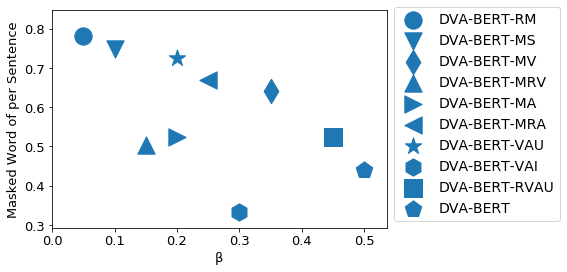

In [26]:
plt.figure(figsize=(6, 4))

lo = plt.scatter(0.05, mask_word_count['VA_BERT_random_mask']/807, marker='o', s=300, color='#1f77b4')
ll = plt.scatter(0.1, mask_word_count['VA_BERT_mask_sentiment']/807, marker='v', s=300, color='#1f77b4')
l  = plt.scatter(0.35, mask_word_count['VA_BERT_mask_sentiment_prob_V']/807, marker='d', s=300, color='#1f77b4')
a  = plt.scatter(0.15, mask_word_count['VA_BERT_mask_sentiment_prob_reverse_V']/807, marker='^', s=300, color='#1f77b4')
h  = plt.scatter(0.2, mask_word_count['VA_BERT_mask_sentiment_prob_A']/807, marker='>', s=300, color='#1f77b4')
hh = plt.scatter(0.25, mask_word_count['VA_BERT_mask_sentiment_prob_reverse_A']/807, marker='<', s=300, color='#1f77b4')
ho = plt.scatter(0.2, mask_word_count['VA_BERT_mask_sentiment_prob_Union']/807, marker='*', s=300, color='#1f77b4')
hp = plt.scatter(0.3, mask_word_count['VA_BERT_mask_sentiment_prob_Intersection']/807, marker='h', s=300, color='#1f77b4')
hq = plt.scatter(0.45, mask_word_count['VA_BERT_mask_sentiment_prob_Union_reverse']/807, marker='s', s=300, color='#1f77b4')
hr = plt.scatter(0.5, mask_word_count['VA_BERT_mask_sentiment_prob_Intersection_reverse']/807, marker='p', s=300, color='#1f77b4')

plt.legend((lo, ll, l, a, h, hh, ho, hp, hq, hr),
           ('DVA-BERT-RM', 'DVA-BERT-MS', 'DVA-BERT-MV', 'DVA-BERT-MRV', 'DVA-BERT-MA', 'DVA-BERT-MRA', 'DVA-BERT-VAU', 'DVA-BERT-VAI',  'DVA-BERT-RVAU', 'DVA-BERT'),
           scatterpoints=1,
           loc='lower left',
           ncol=1,
           fontsize=14,
           bbox_to_anchor=(1,0)
          )

plt.ylabel("Masked Word of per Sentence", size=13)
plt.xlabel("β", size=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.savefig('beta.png', dpi=300, bbox_inches='tight')
plt.show()